In [1]:
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, widgets
import numpy as np
from aicsimageio import AICSImage
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.signal import butter, filtfilt
from tqdm import tqdm
from skimage import io, filters, morphology, img_as_ubyte, img_as_uint
from skimage.filters import rank
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imsave
import cv2
from skimage import measure, feature, color
from skimage.draw import disk
from skimage.feature import blob_dog, blob_log, blob_doh
import heapq

In [2]:
# Open the .ims file
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_3_2024-01-11_Confocal_01.08.43_DragonflyUser.ims'

image = AICSImage('/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_2_2024-01-11_Confocal_01.30.50_DragonflyUser.ims')

# Get the image data as a numpy array
image_data = image.get_image_data("ZYX", S=0, T=0, C=0)

SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.


In [3]:
def show_image(i):
    plt.figure(dpi=150)
    plt.imshow(image_data[i], cmap='gray')
    plt.axis('off')
    plt.show()

slider = widgets.IntSlider(min=0, max=len(image_data)-1, step=1, value=0)
widgets.interact(show_image, i=slider)

interactive(children=(IntSlider(value=0, description='i', max=286), Output()), _dom_classes=('widget-interact'…

<function __main__.show_image(i)>

In [4]:
def subtractflatfield(input_img):
    grayscale_img = input_img
    poly2d_fcn = lambda xy, a, b, c, d, e, f: a + b*xy[0] + c*xy[1] + d*xy[0]*xy[0] + e*xy[1]*xy[1] + f*xy[0]*xy[1]

    y, x = np.indices(grayscale_img.shape)

    x_co = x.flatten()
    y_co = y.flatten()
    pix_val = grayscale_img.flatten()

    p0 = [1, 1, 1, 1, 1, 1]
    popt, _ = curve_fit(poly2d_fcn, (x_co, y_co), pix_val, p0=p0) 
    flat_field_img = poly2d_fcn((x_co, y_co), *popt).reshape(grayscale_img.shape)
    fit_img = grayscale_img - (flat_field_img)

    return fit_img

In [5]:
# for i in tqdm(range(len(image_data))):
#     image_data[i] = subtractflatfield(image_data[i])

In [6]:
frame_mean = []
frame_min = []
frame_max = []
frame_std = []
frame_95 = []
frame_05 = []
for i in range(len(image_data)):
    frame_mean.append(np.mean(image_data[i]))
    frame_min.append(np.min(image_data[i]))
    frame_max.append(np.max(image_data[i]))
    frame_std.append(np.std(image_data[i]))
    frame_95.append(np.percentile(image_data[i], 95))
    frame_05.append(np.percentile(image_data[i], 5))

plusband = []
minusband = []
for i in range(len(image_data)):
    plusband.append(frame_mean[i] + frame_std[i])
    minusband.append(frame_mean[i] - frame_std[i])

frame_mean_top = []
frame_mean_bottom = []
for i in range(len(image_data)//2):
    frame_mean_bottom.append(frame_mean[i])

for i in range(len(image_data)//2, len(image_data)):
    frame_mean_top.append(frame_mean[i])

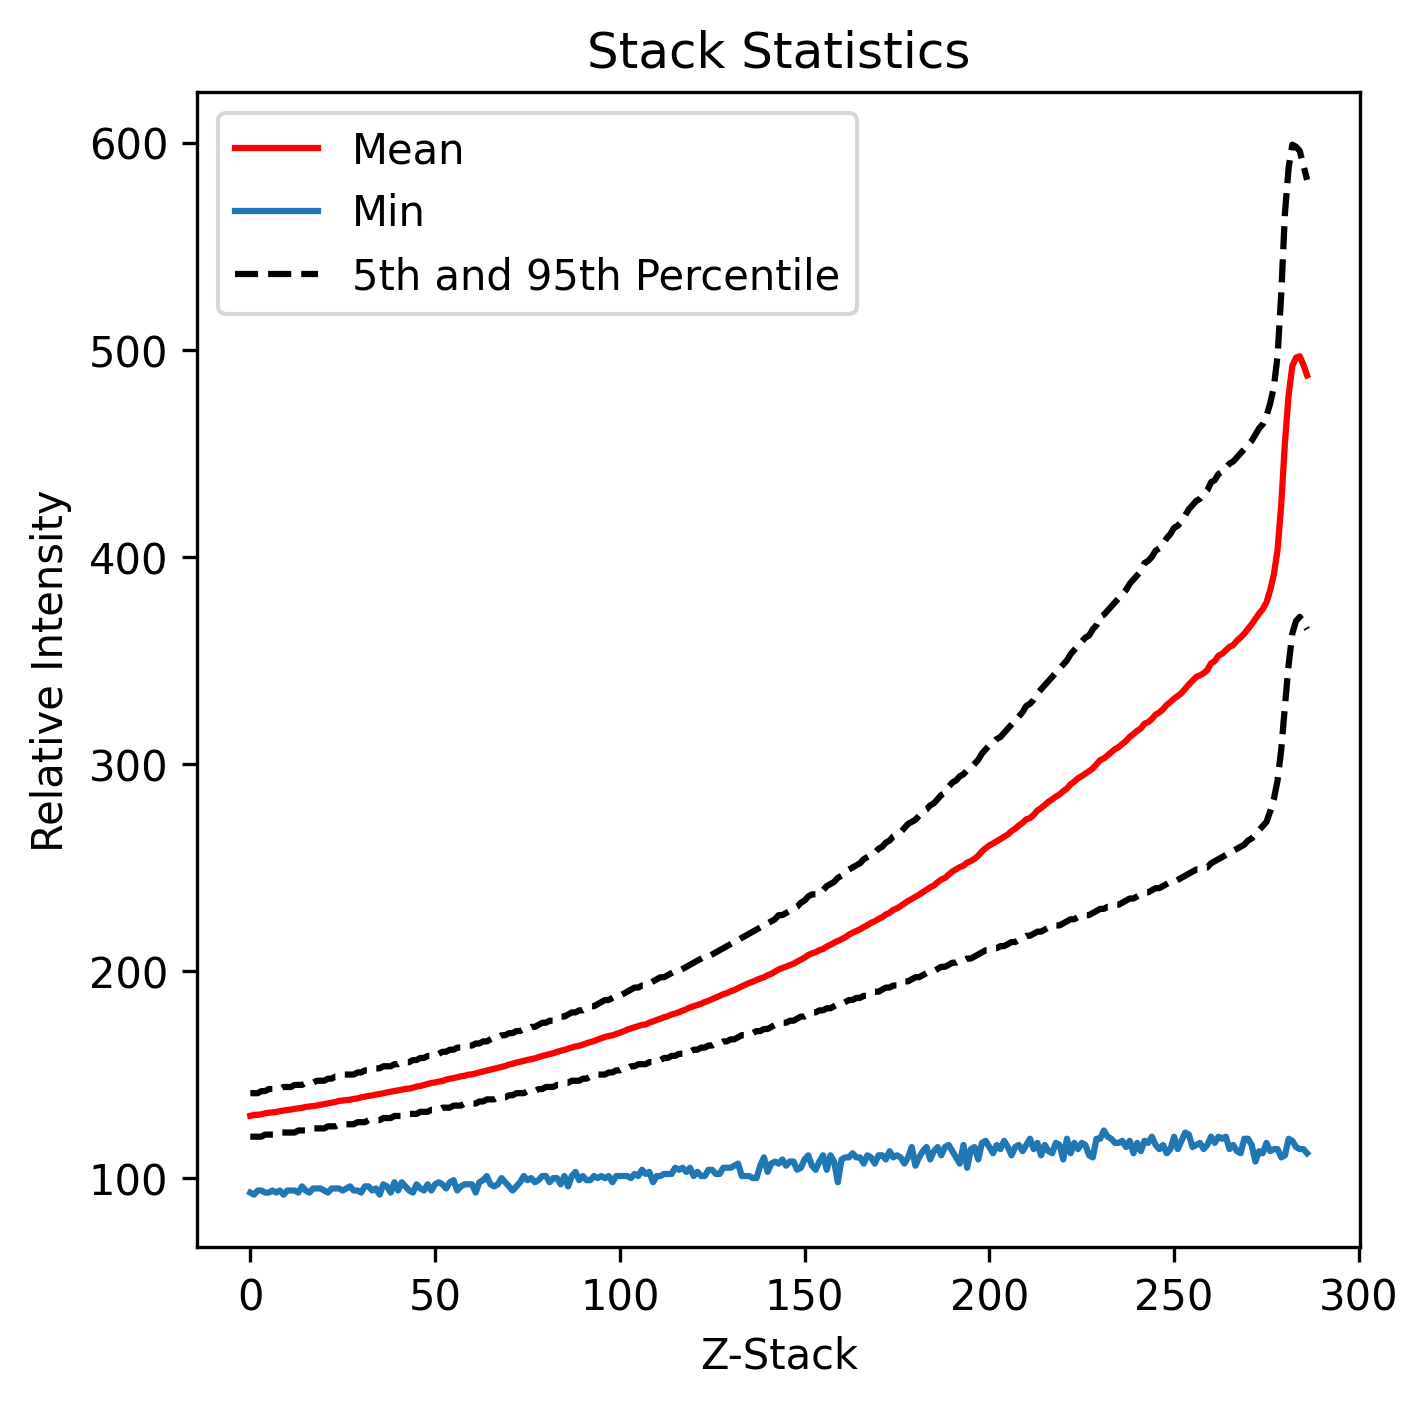

In [7]:
plt.figure(figsize=(5,5), dpi=300)
plt.plot(frame_mean, label='Mean', color='red')
plt.plot(frame_min, label='Min')
# plt.plot(frame_max, label='Max')
plt.plot(frame_95, label='5th and 95th Percentile', color='black', ls = '--')
plt.plot(frame_05, color='black', ls = '--')
# plt.plot(plusband, color='black', ls = (0, (2, 5)))
# plt.plot(minusband, color='black', ls = (0, (2, 5)))

plt.title('Stack Statistics')
plt.xlabel('Z-Stack')
plt.ylabel('Relative Intensity')

plt.legend()

plt.show()

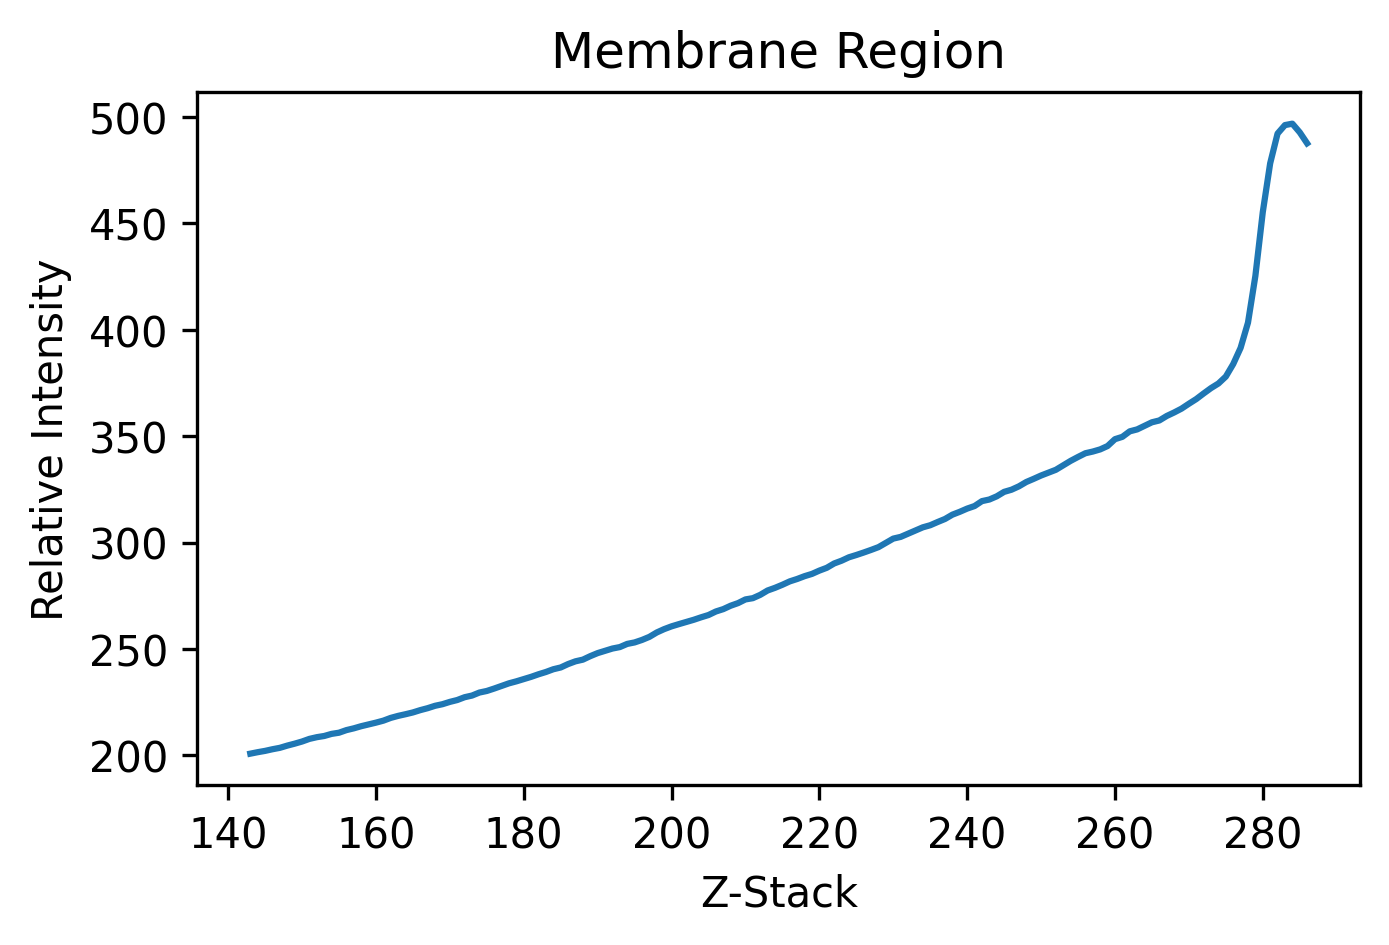

In [8]:
plt.figure(figsize=(5,3), dpi=300)
xhalf_length = len(image_data) // 2
xnew = np.arange(xhalf_length, len(image_data))
plt.plot(xnew, frame_mean_top)
plt.title('Membrane Region')
plt.xlabel('Z-Stack')
plt.ylabel('Relative Intensity')
plt.show()


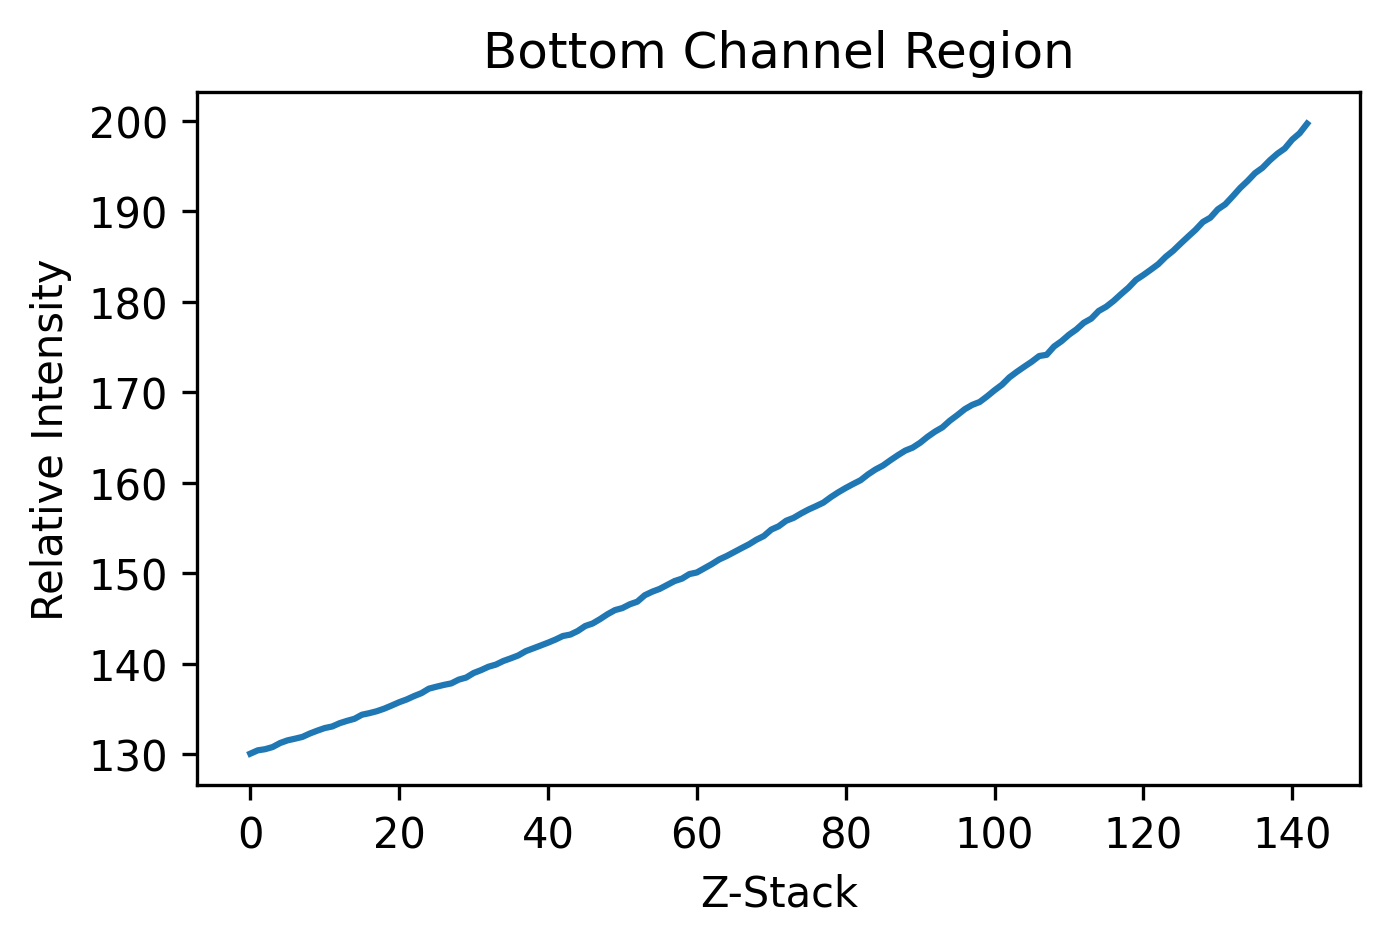

In [9]:
plt.figure(figsize=(5,3), dpi=300)
plt.plot(frame_mean_bottom)
plt.title('Bottom Channel Region')
plt.xlabel('Z-Stack')
plt.ylabel('Relative Intensity')
plt.show()

In [10]:
def background_subtract(img_dat):
    x1 = np.min(img_dat)
    x2 = []
    for i in range(len(img_dat)):
        x2.append(img_dat[i] - x1)

    x2 = np.maximum(x2, 0)

    return x2

background_collect = background_subtract(frame_mean)

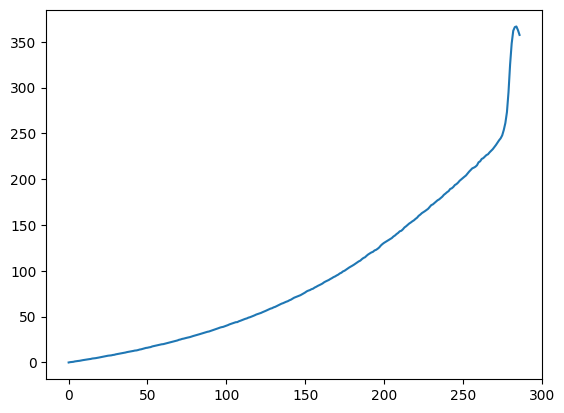

In [11]:
plt.plot(background_collect)

In [12]:
# def least_squares_background_reduction(signal, degree=1):
    
#     x = np.arange(len(signal))
#     A = np.vander(x, degree+1)
#     coeffs, _, _, _ = np.linalg.lstsq(A, signal, rcond=None)
#     background = np.dot(A, coeffs)
#     corrected_signal = signal - background
#     corrected_signal = np.maximum(corrected_signal, 0)

#     return corrected_signal

# corrected_collect = least_squares_background_reduction(np.array(frame_mean))

In [13]:
# # Create a high-pass filter
# b, a = butter(1, 0.01, btype='high')
# corrected_collect2 = filtfilt(b, a, frame_mean)
# corrected_collect2 = np.maximum(corrected_collect2, 0)
# plt.plot(corrected_collect2)

In [14]:
# # High pass filter peak detection

# peaks, _ = find_peaks(corrected_collect2, height = 1)
# print(peaks)
# print(corrected_collect2[peaks])
# botc = np.mean(corrected_collect2[(peaks[0]-5):(peaks[0]+5)])
# midc = np.mean(corrected_collect2[(peaks[0]+5):(peaks[1]-5)])
# topc = np.mean(corrected_collect2[(peaks[1]-5):(peaks[1]+5)])


In [15]:
# print(botc, midc, topc) 

In [16]:
# # High pass filter transmigration ratio
# (botc+midc)/(botc+midc+topc)*100

In [17]:
# # Raw with baseline subtraction background reduction
peaks2, _ = find_peaks(background_collect, height = 1)
print(peaks2)
# print(background_collect[peaks2])
# b_size = 3
# botc2= np.mean(background_collect[(peaks2[0]-b_size):(peaks2[0]+b_size)])
# midc2 = np.mean(background_collect[(peaks2[0]+b_size+1):(peaks2[1]-b_size-1)])
# topc2 = np.mean(background_collect[(peaks2[1]-b_size):(peaks2[1]+b_size)])
# print(botc2, midc2, topc2)

[284]


In [18]:
# # Raw with baseline subtraction background reduction
# (botc2+midc2)/(botc2+midc2+topc2)*100

In [19]:
# # Break middle section into multiple means via chunks. Lower number means more chunks

# chunk_div = 10
# midtot = background_collect[(peaks2[0]+6):(peaks2[1]-6)]
# num_chunks = len(midtot) // chunk_div
# midtot_chunks = midtot[:num_chunks * chunk_div].reshape(-1, chunk_div)
# mean_chunks = midtot_chunks.mean(axis=1)

# print(mean_chunks)

In [20]:
# # Percent transmigrated
# (botc2+midc2)/(botc2+midc2+topc2)*100

In [21]:
# # Percent on bottom channel region
# botc2/(botc2+midc2+topc2)*100

In [22]:
# # Percent on top channel region
# topc2/(botc2+midc2+topc2)*100

In [23]:
# # Percent in middle/floating
# midc2/(botc2+midc2+topc2)*100

In [24]:
# # Comparison of detected peaks only, transmigration ratio
# botc2/(botc2+topc2)*100

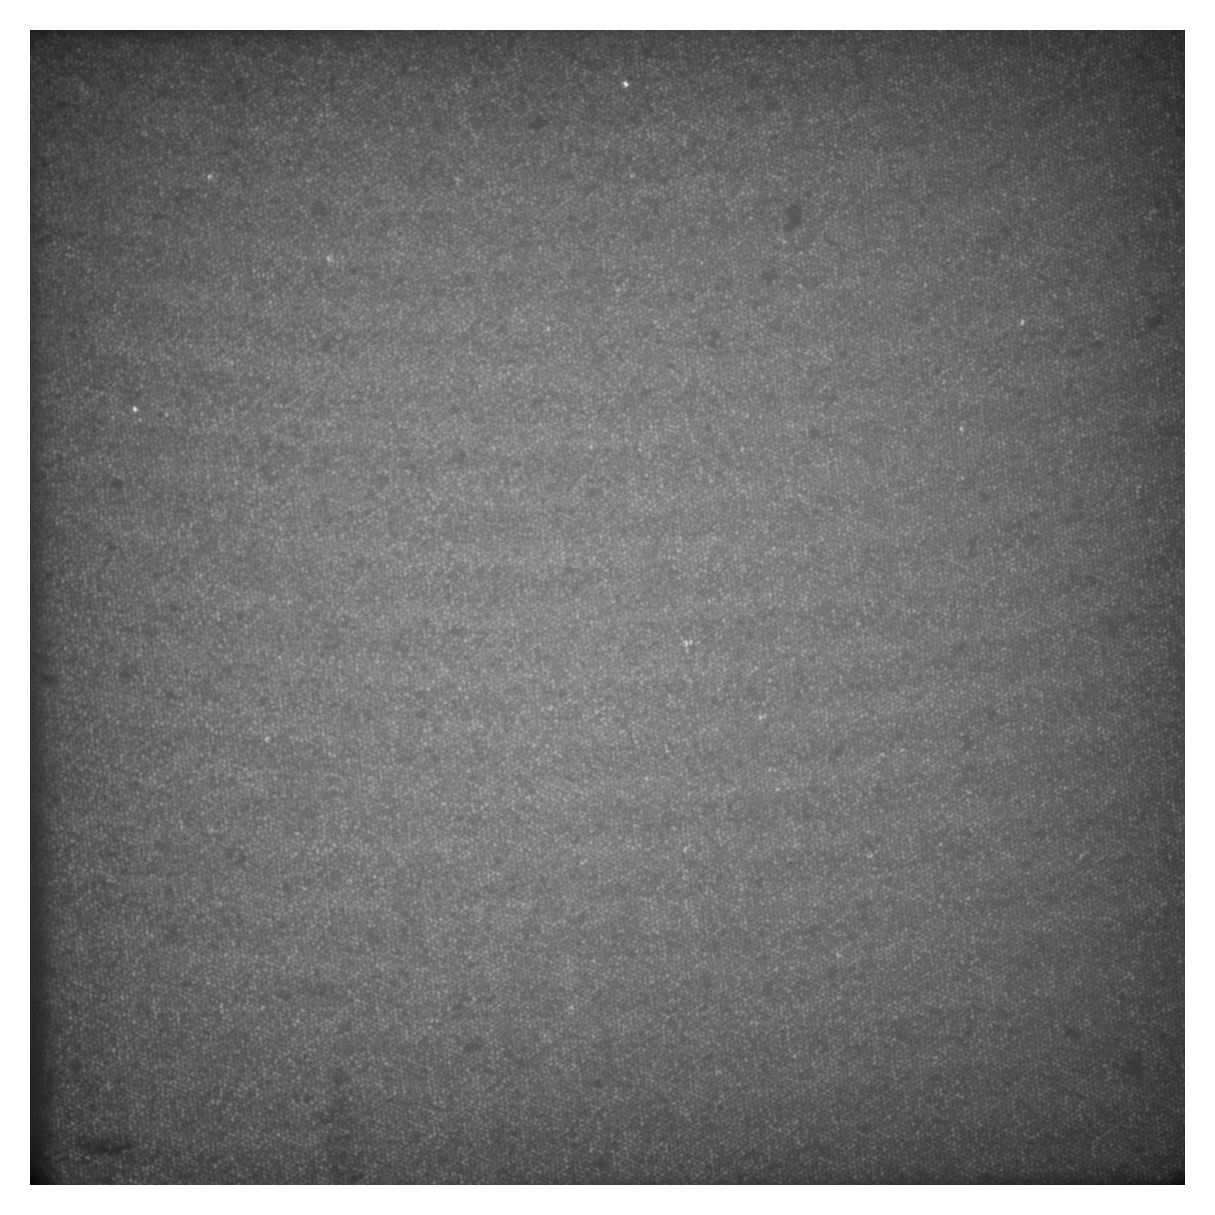

In [25]:
test_im1 = image_data[peaks2[0]-4]
plt.figure(figsize=(5,5), dpi=300)
plt.imshow(test_im1, cmap='gray')
plt.axis('off')
plt.show()

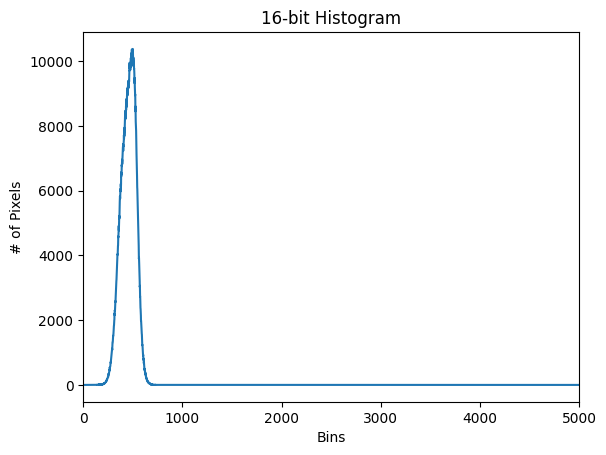

In [26]:
test_im1hist = cv2.calcHist([test_im1], [0], None, [65536], [0, 65536])
plt.figure()
plt.title("16-bit Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(test_im1hist)
plt.xlim([0, 5000])
plt.show()

In [27]:
hist_key = {}
search_mod = 10

for i in range(peaks2[0]-search_mod, peaks2[0]):
    if i > 0:
        hist_key[i] = image_data[i]

for i in range(peaks2[0], peaks2[0]+search_mod+1):
    if i < len(image_data):
        hist_key[i] = image_data[i]

In [28]:
len(hist_key)

13

In [29]:
# hist_list = []
# hist_list.append(image_data[peaks2[0]])
# for i in range(4):
#     if len(image_data)-4 > 0:
#         hist_list.insert(0, image_data[peaks2[0]-i-1])
#     if peaks2[0]+4 < len(image_data):
#         hist_list.append(image_data[peaks2[0]+i+1])

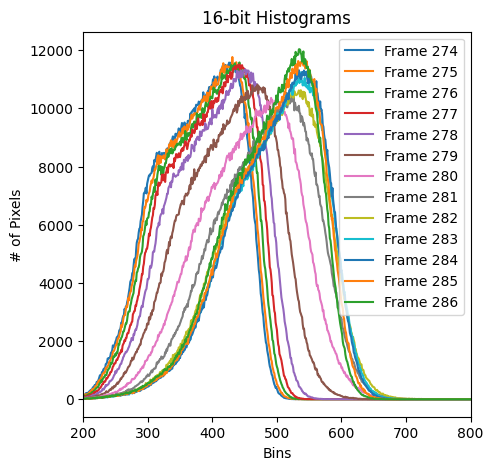

In [30]:
hist_listgraph = []

for i in hist_key.keys():
    hist_listgraph.append(cv2.calcHist([hist_key[i]], [0], None, [65536], [0, 65536]))

plt.figure(figsize=(5,5), dpi=100)
for i in range(len(hist_listgraph)):
    plt.plot(hist_listgraph[i])
plt.title('16-bit Histograms')
plt.xlabel('Bins')
plt.ylabel('# of Pixels')
plt.xlim([200, 800])
plot_leg = []
for i in hist_key.keys():
    plot_leg.append('Frame ' + str(i))
plt.legend(plot_leg)
plt.show()

In [105]:
hist_stdev = {}
for i in hist_key.keys():
    hist_stdev[i] = np.std(hist_key[i])

In [106]:
print(f'Max Stdev: ' + str(np.max(list(hist_stdev.values()))) + ' at Frame ' + str(max(hist_stdev, key=hist_stdev.get)))

Max Stdev: 74.68935108293746 at Frame 281


In [107]:
# mem_layer = max(hist_stdev, key=hist_stdev.get)

In [108]:
# Mem layer ID second test. Ultimately comparing contrast assessment vs. laplacian focus measure vs tenengrad focus measure
hist_laplace = {}
for i in hist_key.keys():
    hist_laplace[i] = cv2.Laplacian(hist_key[i], cv2.CV_64F)

hist_laplace_focusemeasure = {}
for i in hist_laplace.keys():
    hist_laplace_focusemeasure[i] = np.var(hist_laplace[i])

In [109]:
print(hist_laplace_focusemeasure)

{274: 4207.303589494886, 275: 4246.736725621511, 276: 4353.897377854736, 277: 4457.183702185664, 278: 4672.626302961159, 279: 5204.03402465755, 280: 5854.493511558468, 281: 5995.207353205829, 282: 6204.880024320601, 283: 6114.127211583656, 284: 6099.608443477836, 285: 5998.483107254163, 286: 5870.758647460638}


In [110]:
print(f'Max Laplace Focus Measure: ' + str(np.max(list(hist_laplace_focusemeasure.values()))) + ' at Frame ' + str(max(hist_laplace_focusemeasure, key=hist_laplace_focusemeasure.get)))

Max Laplace Focus Measure: 6204.880024320601 at Frame 282


In [111]:
# Calculate the Tenengrad focus measure as the variance of the gradient magnitude
hist_tenengrad_focusemeasure = {}

for i in hist_key.keys():
    sobelx = cv2.Sobel(hist_key[i], cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(hist_key[i], cv2.CV_64F, 0, 1, ksize=5)

    magnitude = np.sqrt(sobelx**2 + sobely**2)

    hist_tenengrad_focusemeasure[i] = np.var(magnitude)

In [112]:
print(hist_tenengrad_focusemeasure)

{274: 69001.83888774163, 275: 70262.10489961728, 276: 72684.94392587186, 277: 83959.07705217478, 278: 166796.3291927702, 279: 549111.6662004465, 280: 923528.9385392959, 281: 690300.3490902951, 282: 584605.6937460913, 283: 355875.34894901275, 284: 291309.64165390853, 285: 234863.3069287353, 286: 196245.01363612525}


In [113]:
print(f'Max Tenengrad Focus Measure: ' + str(np.max(list(hist_tenengrad_focusemeasure.values()))) + ' at Frame ' + str(max(hist_tenengrad_focusemeasure, key=hist_tenengrad_focusemeasure.get)))

Max Tenengrad Focus Measure: 923528.9385392959 at Frame 280


In [114]:
hist_max = {}
for i in hist_key.keys():
    hist_max[i] = np.max(hist_key[i])

In [115]:
print(f'Max Intensity: ' + str(np.max(list(hist_max.values()))) + ' at Frame ' + str(max(hist_max, key=hist_max.get)))

Max Intensity: 946 at Frame 280


In [184]:
weight_mat = [1, 1, 1]
focus_margins = []

stdev_two_largest = heapq.nlargest(2, hist_stdev.values())
laplace_two_largest = heapq.nlargest(2, hist_laplace_focusemeasure.values())
tenengrad_two_largest = heapq.nlargest(2, hist_tenengrad_focusemeasure.values())

# % diff is overweight on tenengrad, underweight on stdev and laplace
# weight_mat[0] = (stdev_two_largest[0]-stdev_two_largest[1])/((stdev_two_largest[0]+stdev_two_largest[1])/2)*100
# weight_mat[1] = (laplace_two_largest[0]-laplace_two_largest[1])/((laplace_two_largest[0]+laplace_two_largest[1])/2)*100
# weight_mat[2] = (tenengrad_two_largest[0]-tenengrad_two_largest[1])/((tenengrad_two_largest[0]+tenengrad_two_largest[1])/2)*(100)

stdev_stdev = np.std(list(hist_stdev.values()))
laplace_stdev = np.std(list(hist_laplace_focusemeasure.values()))
tenengrad_stdev = np.std(list(hist_tenengrad_focusemeasure.values()))

# Inverse standard deviation, of each focus measure, may be more appropriate
weight_mat[0] = 1 / stdev_stdev
weight_mat[1] = 1 / laplace_stdev
weight_mat[2] = 1 / tenengrad_stdev

In [185]:
weight_mat

[0.21316892536812432, 0.0012726930694307917, 3.773427735647493e-06]

In [187]:
focus_ensemble = []
focus_ensemble.append(max(hist_stdev, key=hist_stdev.get))
focus_ensemble.append(max(hist_laplace_focusemeasure, key=hist_laplace_focusemeasure.get))
focus_ensemble.append(max(hist_tenengrad_focusemeasure, key=hist_tenengrad_focusemeasure.get))

In [188]:
voting_power = []
for i in range(len(focus_ensemble)):
    voting_power.append((focus_ensemble[i], weight_mat[i]))

vote = {}
for frame_num, weighted_vote in voting_power:
    if frame_num in vote:
        vote[frame_num] += weighted_vote

    else:
        vote[frame_num] = weighted_vote


In [213]:
print(f'Max Ensemble Vote: ' + str(np.max(list(vote.values()))) + ' points for Frame ' + str(max(vote, key=vote.get)))

Max Ensemble Vote: 0.21316892536812432 points for Frame 281


In [214]:
mem_layer = max(vote, key=vote.get)
# mem_layer = round(np.mean(focus_ensemble))

In [215]:
bud_layer = mem_layer-1

In [216]:
# img_variance = np.var(test_im1)  # Find overall variance
# img_sigma = np.sqrt(img_variance) # Find standard deviation
# smooth_img = filters.gaussian(test_im1, sigma=img_sigma)

In [217]:
# plt.imshow(smooth_img, cmap='gray')

In [218]:
# # Sliding otsu to preserve dot morphology. This is a simple approach.
# ubyte_img = img_as_ubyte(smooth_img) # Pixel scaling to 8-bit, needed to run sliding otsu or else it throws an error.
# test_im_ubyte = img_as_ubyte(test_im1)
# rad = 10 # Radius of the sliding window, completely arbitrary. Change for image as needed.
# local_otsu = rank.otsu(ubyte_img, disk(rad)) # Sliding otsu.
# mask_test = ubyte_img >= local_otsu*1.1 # 1.1 is a fudge factor to make the mask a bit bigger, also removes nonsense output.
# masked_img = np.where(mask_test, test_im_ubyte, 0) # Apply mask on grayscale image, set all non-masked pixels to 0.

In [219]:
# plt.imshow(test_im_ubyte, cmap='gray')

In [220]:
# thresh_imtest = filters.threshold_otsu(test_im_ubyte)
# bin_test = test_im_ubyte > thresh_imtest
# plt.imshow(bin_test, cmap='gray')

In [221]:
# imsave('/Users/moose/Desktop/test_im1.tif', test_im1)

In [222]:
bud_img = hist_key[bud_layer]

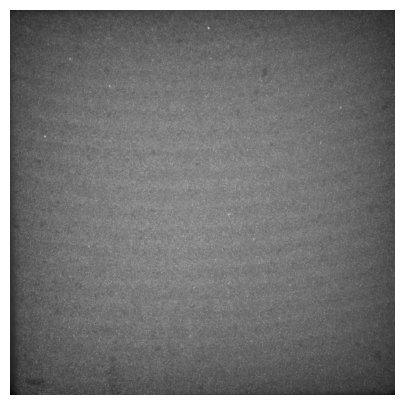

In [223]:
normalized_img = (bud_img - np.min(bud_img)) / (np.max(bud_img) - np.min(bud_img))
np.clip(normalized_img, 0, 1, out=normalized_img)
normalized_img = img_as_ubyte(normalized_img)

plt.figure(figsize=(5,5), dpi=100)
plt.axis('off')
plt.imshow(normalized_img, cmap='gray')
plt.show()

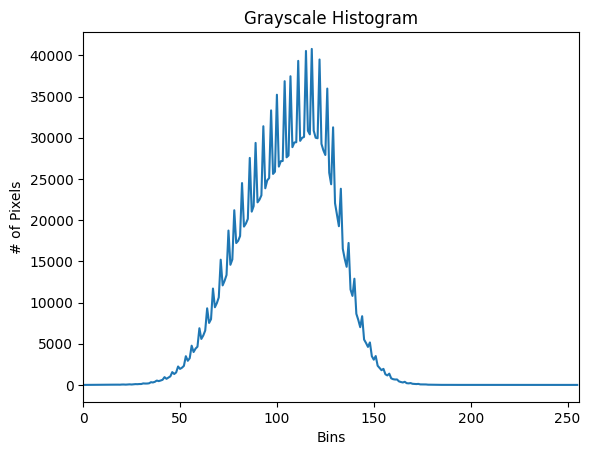

In [224]:
norm_hist = cv2.calcHist([normalized_img], [0], None, [256], [0, 256])
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(norm_hist)
plt.xlim([0, 256])
plt.show()

In [201]:
normalized_img.dtype

dtype('uint8')

In [202]:
normalized_img.shape

(1400, 1400)

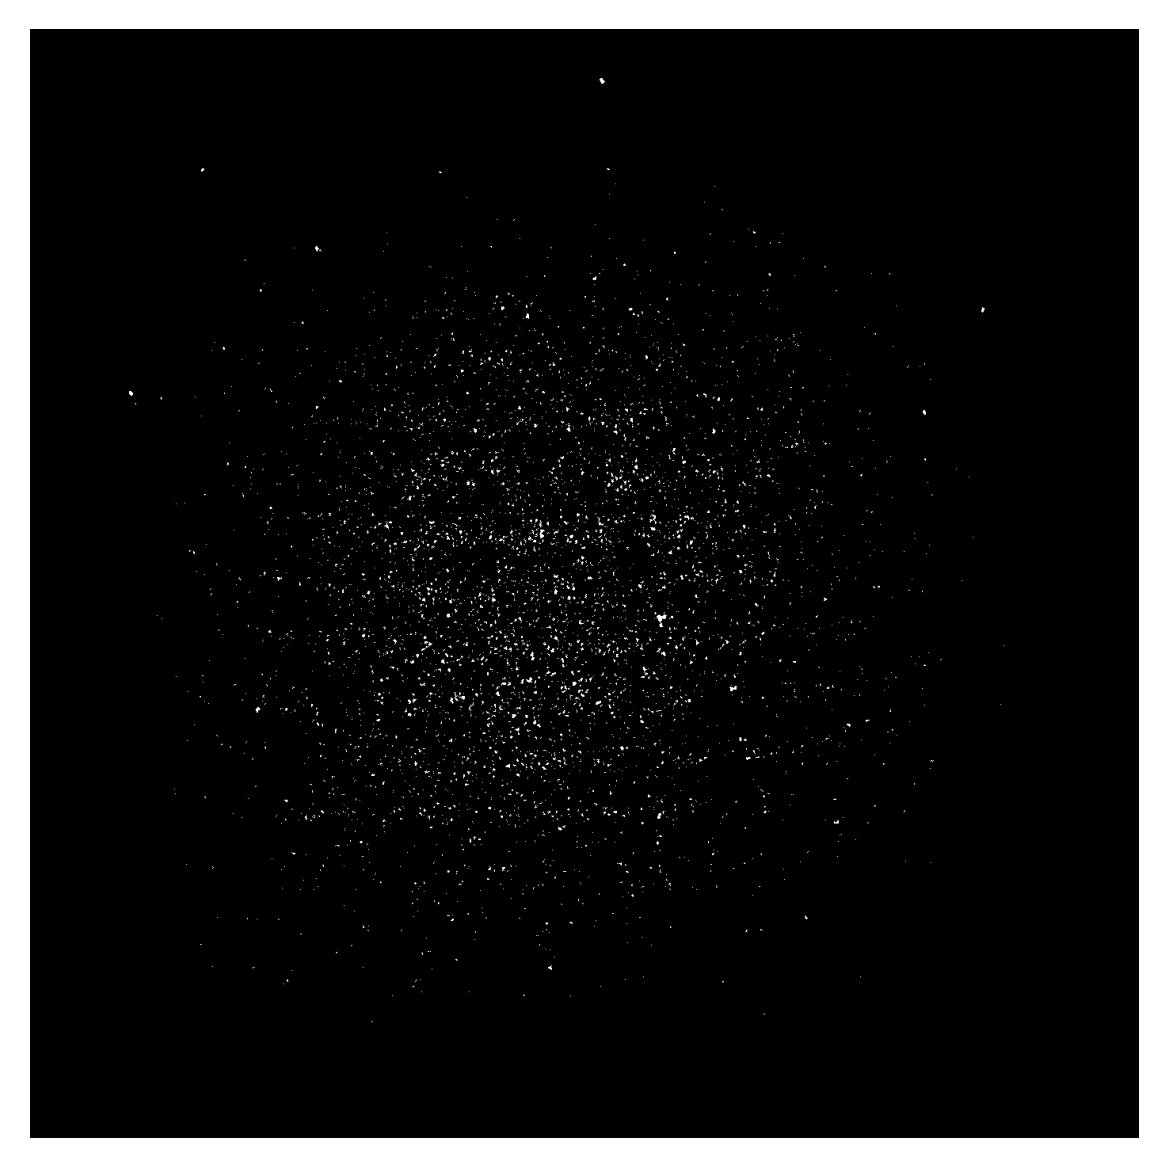

In [203]:
threshold_value = 0.6*256
_, binary_image = cv2.threshold(normalized_img, threshold_value, 256, cv2.THRESH_BINARY)

plt.figure(dpi=300)
plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.show()

In [204]:
# kernel = np.ones((3,3),np.uint8)
# eroded_image = cv2.erode(binary_image, kernel, iterations = 1)
# dilated_image = cv2.dilate(eroded_image, kernel, iterations = 1)

# plt.figure(dpi=300)
# plt.imshow(dilated_image, cmap='gray')
# plt.axis('off')
# plt.show()

In [205]:
# labels = measure.label(binary_image, connectivity=2)
# # Count the number of dots
# n_dots = len(measure.regionprops(labels))
# print(f'Number of dots: {n_dots}')

In [206]:
# labels = measure.label(binary_image, connectivity=2)
# props = measure.regionprops(labels)

# # Create an RGB version of the original image so we can overlay colored dots
# rgb_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)

# # Iterate over each detected region
# for prop in props:
#     # Get the coordinates of the center of the dot (rounded to nearest integer)
#     y, x = [int(round(coord)) for coord in prop.centroid]
    
#     # Draw a red dot at the center of each region
#     rr, cc = disk((x, y), radius=5)
#     rgb_image[rr, cc] = (255, 0, 0)  # RGB color for red

# plt.figure(dpi=300)
# plt.imshow(rgb_image)
# plt.axis('off')
# plt.show()

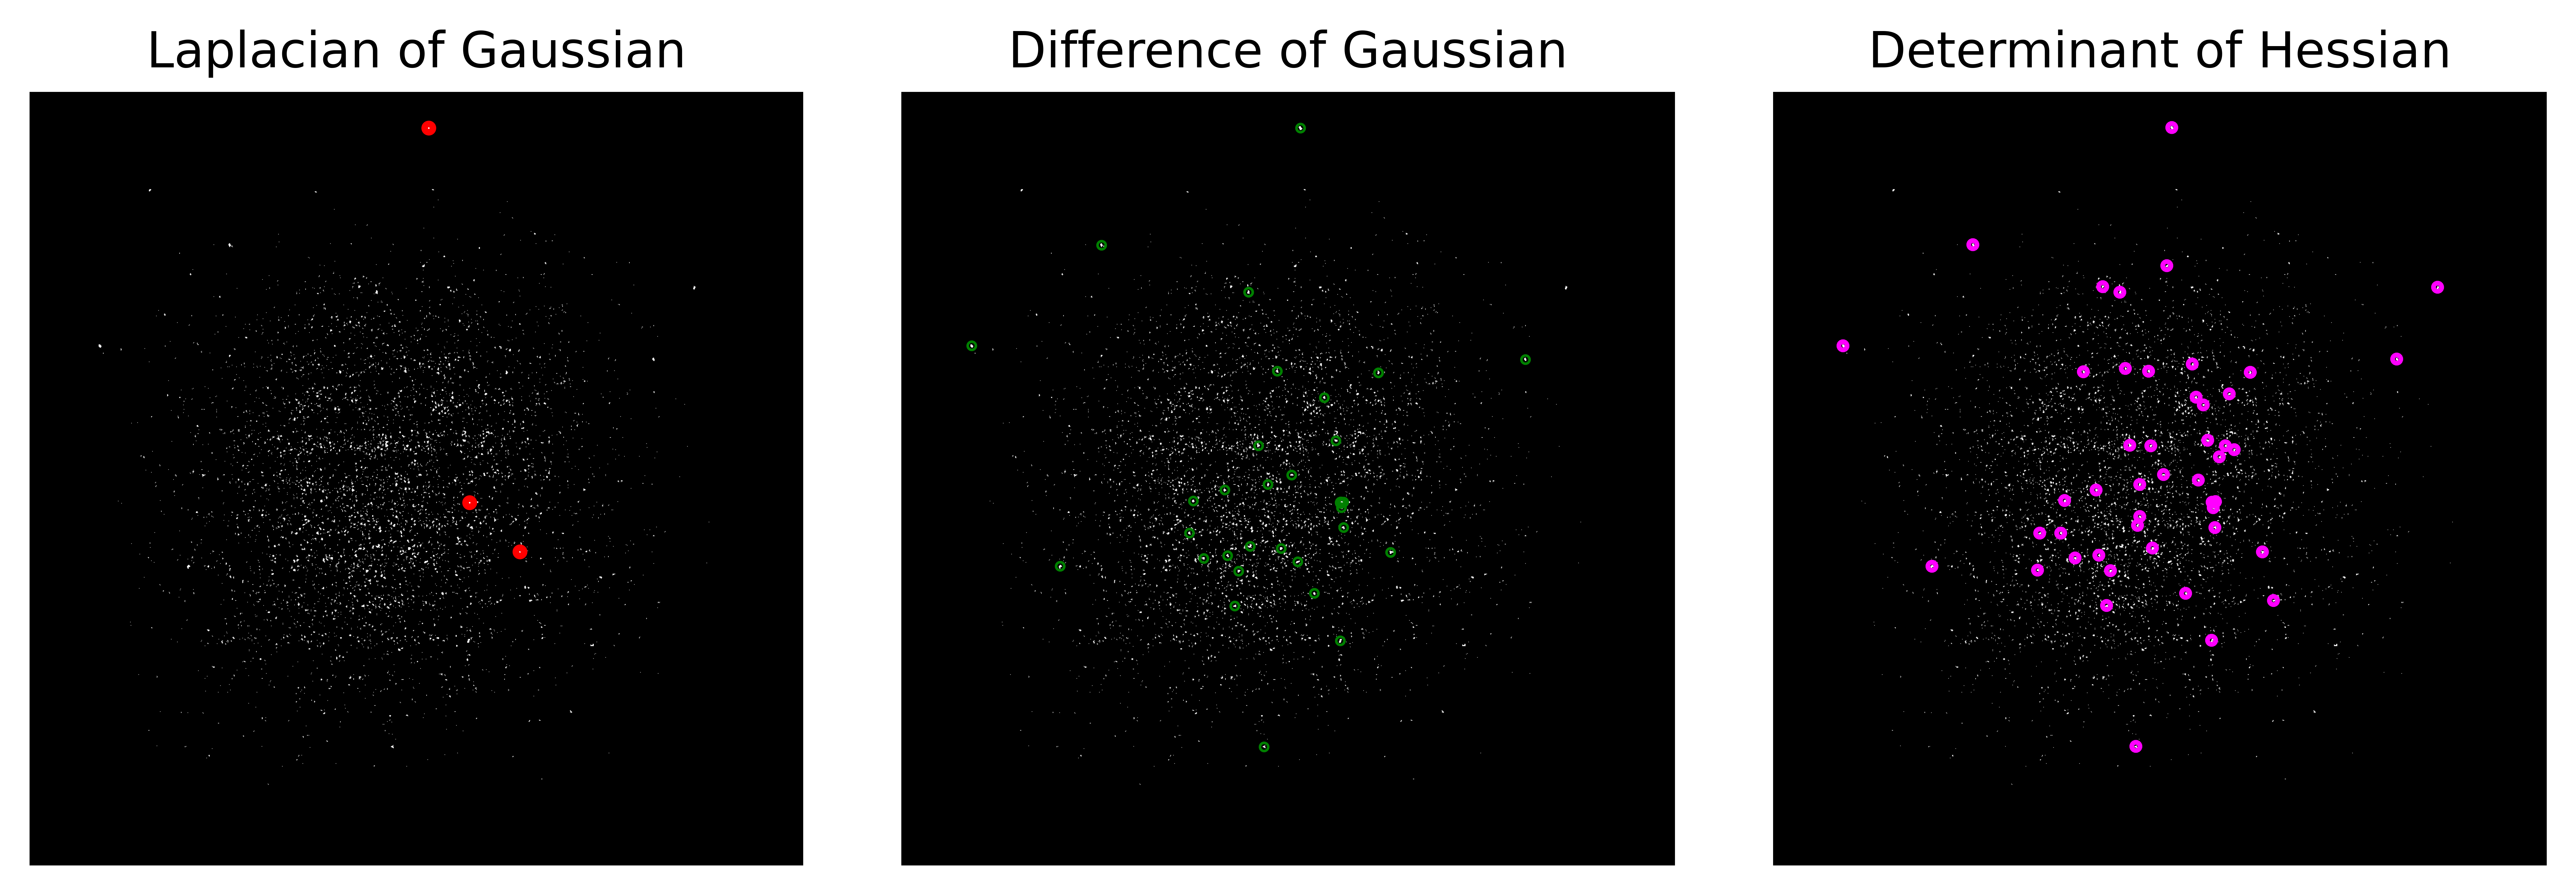

In [207]:
blobs_log = blob_log(binary_image, max_sigma=30, num_sigma=10, threshold=0.3)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

blobs_dog = blob_dog(binary_image, max_sigma=30, threshold=0.3)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

blobs_doh = blob_doh(binary_image, max_sigma=30, threshold=0.03)

min_radius = 1.5  # Minimum acceptable blob radius
max_radius = 15  # Maximum acceptable blob radius

# Filter blobs based on their radii
blobs_log = [blob for blob in blobs_log if min_radius <= blob[2] <= max_radius]
blobs_dog = [blob for blob in blobs_dog if min_radius <= blob[2] <= max_radius]
blobs_doh = [blob for blob in blobs_doh if min_radius <= blob[2] <= max_radius]

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['red', 'green', 'magenta']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, dpi=1000)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(binary_image, cmap='gray')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()


In [208]:
len(blobs_dog)

31

In [209]:
print(blobs_dog)

[array([826.       , 687.       ,   2.2627417]), array([459.       , 127.       ,   2.2627417]), array([740.       , 528.       ,   2.2627417]), array([858.       , 287.       ,   2.2627417]), array([867.       , 610.       ,   2.2627417]), array([ 65.       , 722.       ,   2.2627417]), array([362.       , 628.       ,   2.2627417]), array([631.       , 786.       ,   2.2627417]), array([798.       , 521.       ,   2.2627417]), array([ 484.       , 1129.       ,    2.2627417]), array([907.       , 747.       ,   2.2627417]), array([508.       , 863.       ,   2.2627417]), array([720.       , 585.       ,   2.2627417]), array([710.       , 663.       ,   2.2627417]), array([930.       , 603.       ,   2.2627417]), array([277.       , 362.       ,   2.2627417]), array([553.       , 765.       ,   2.2627417]), array([839.       , 590.       ,   2.2627417]), array([788.       , 800.       ,   2.2627417]), array([505.       , 680.       ,   2.2627417]), array([752.       , 796.       ,   2

In [210]:
print(mem_layer)

281


In [211]:
voting_power

[(281, 0.21316892536812432),
 (282, 0.0012726930694307917),
 (280, 3.773427735647493e-06)]

In [212]:
vote

{281: 0.21316892536812432,
 282: 0.0012726930694307917,
 280: 3.773427735647493e-06}